In [1]:
import sys
import numpy as np
sys.path.append('../../../nn')
from mynn import *
from mydata import *

from Adam import Adam
import operator
from functools import reduce
from functools import partial
import matplotlib.pyplot as plt
from timeit import default_timer
import numpy as np

from torch.autograd import Variable


#torch.manual_seed(0)
#np.random.seed(0)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [38]:
def de(self,data_domain,w=1e3):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)

    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    ddu_y = torch.autograd.grad(
        du[:,1],data_domain, 
        grad_outputs=torch.ones_like(du[:,1]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    f = ddu_x[:,0].reshape(-1,1)+ddu_y[:,1].reshape(-1,1) + ((w/20)**2)*u.reshape(-1,1)
    return f

def bc_b(self,data_bc):
#    data_bc = torch.cat ([data_bc[:,:2],torch.zeros((data_bc.shape[0],1),requires_grad=True) ],axis =1)
    u = self(data_bc)
    du = torch.autograd.grad(
        u, data_bc, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    return du[:,1].reshape(-1,1)

def bc_l(self,data_bc):
    #data_bc = torch.cat ([data_bc[:,0].reshape(-1,1),torch.zeros((data_bc.shape[0],1),requires_grad=True), data_bc[:,2].reshape(-1,1)],axis =1)
    u = self(data_bc)
    
    du = torch.autograd.grad(
        u, data_bc, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    return du[:,0].reshape(-1,1)

def bc_r(self,data_bc):
    #data_bc = torch.cat ([data_bc[:,0].reshape(-1,1),torch.ones((data_bc.shape[0],1),requires_grad=True), data_bc[:,2].reshape(-1,1)],axis =1)

    u = self(data_bc)
    
    du = torch.autograd.grad(
        u, data_bc, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    return du[:,0].reshape(-1,1)


def bc_u(self,data_bc):
    #data_bc = torch.cat ([data_bc[:,:2],torch.ones((data_bc.shape[0],1),requires_grad=True) ],axis =1)

    u = self(data_bc)
    
    du = torch.autograd.grad(
        u, data_bc, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    f = torch.where((data_bc[:,0] > 0.35) & (data_bc[:,0] < 0.65), 1, 0)
    return du[:,1].reshape(-1,1) - f.reshape(-1,1)

FNN.de = de
FNN.bc_b = bc_b
FNN.bc_l = bc_l
FNN.bc_r = bc_r
FNN.bc_u = bc_u

In [39]:
M = 324
N = 100

ntrain = M//2

inputs = np.load("../../../../data//Helmholtz_inputs.npy")   
outputs = np.load("../../../../data/Helmholtz_outputs.npy") 

train_inputs = inputs[:,:,:M//2]
train_outputs = outputs[:,:,:M//2]

#test_inputs  = np.reshape(inputs[:,:,M//2:M], (-1, M-M//2))

xgrid = np.linspace(0,1,N+1)

Y, X = np.meshgrid(xgrid, xgrid)
# test

X_upper = np.reshape(X, -1)
Y_upper = np.reshape(Y, -1)
N_upper = len(X_upper)

x_train = np.zeros((M//2 * N_upper, 3), dtype = np.float32)
y_train = np.zeros(M//2 * N_upper, dtype = np.float32)

for i in range(M//2):
    d_range = range(i*N_upper, (i + 1)*N_upper)
    x_train[d_range , 2]   = np.reshape(train_inputs[:, :, i], -1)
    x_train[d_range , 0]     = X_upper
    x_train[d_range , 1] = Y_upper 
    y_train[d_range] = np.reshape(train_outputs[:, :, i], -1)

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).unsqueeze(-1)

batch_size = 1024

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

In [40]:
from pyDOE import lhs

def samples_space(size,maxl=1):
    t_f_train = lhs(2, size)*maxl
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [41]:
def data_pde(size,minp,maxp):

    xy, param = samples_space(size),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xy,param.reshape(-1,1)))).float()
    
    x,y, param  = torch.tensor(xy[:,0]).reshape(-1,1),torch.tensor(xy[:,1]).reshape(-1,1),torch.tensor(param).reshape(-1,1)

    bc_b = torch.cat([x,torch.zeros_like(x).float(),param],axis = 1).float()

    bc_u = torch.cat([x,torch.ones_like(x).float(),param],axis = 1).float()

    bc_l = torch.cat([torch.zeros_like(x).float(),y, param],axis = 1).float()

    bc_r = torch.cat([torch.ones_like(x).float(),y, param],axis = 1).float()

    return pde_domain,bc_b,bc_l,bc_u,bc_r

In [42]:
def train_adam(pinn,loss,optimizer,epochs,train_loader,minval_param = 0.2,maxval_param = 2):
      print("Starting Adam Training")
      train_loss=[]
      
      for i in range(epochs):
        for j,(x, y) in enumerate(train_loader):
          x, y = x.to(device), y.to(device)

          batch_size_ = x.shape[0]
             
          pde_domain,bc_b,bc_l,bc_u,bc_r = data_pde(batch_size_,minval_param,maxval_param)
          pde_domain,bc_b,bc_l,bc_u,bc_r = pde_domain.to(device),bc_b.to(device),bc_l.to(device),bc_u.to(device),bc_r.to(device)

          pde_domain = Variable(x,requires_grad=True)
          bc_b,bc_u = Variable(bc_b,requires_grad=True),Variable(bc_u,requires_grad=True)
          bc_l,bc_r = Variable(bc_l,requires_grad=True),Variable(bc_r,requires_grad=True)
          
          optimizer.zero_grad()

          pde_pred  = pinn.de(pde_domain)
          down_bc_pred,up_bc_pred = pinn.bc_b(bc_b),pinn.bc_u(bc_u)
          left_bc_pred,right_bc_pred = pinn.bc_l(bc_l),pinn.bc_r(bc_r)
          u = pinn(pde_domain)

          zeros = torch.zeros_like(pde_pred)

          loss_pde = loss(pde_pred,zeros)
          loss_dbc,loss_ubc = loss(down_bc_pred,zeros),loss(up_bc_pred,zeros)
          loss_lbc,loss_rbc = loss(left_bc_pred,zeros),loss(right_bc_pred,zeros)
          loss_f = loss(u,y)

          #Loss =   loss_f + loss_pde + loss_dbc + loss_ubc + loss_lbc + loss_rbc
          Loss = loss_f
          
          train_loss.append(Loss.item())

          if j % 100 == 0:
                  print('Iter %d, Loss: %.5e, Loss_pde: %.5e,Loss_dbc: %.5e,Loss_ubc: %.5e,Loss_lbc: %.5e,Loss_rbc: %.5e' % (i, 
                                          Loss.item(),loss_pde.item(),loss_dbc.item(), loss_ubc.item(),loss_lbc.item(), loss_rbc.item()))      
                  #print('Iter %d, Loss: %.5e, Loss_f: %.5e, Loss_pde: %.5e' % (i,Loss.item(),loss_f.item(),loss_pde.item()))      
          
          Loss.backward() 

          optimizer.step() 
                
      return train_loss

In [43]:
def train_LBFGS(pinn,loss,optimizer, sample_size = 100,minval_param = 0.2,maxval_param = 2):
    print("Starting Training: LBFGS optimizer")
    train_loss=[]

    pde_domain,bc_b,bc_l,bc_u,bc_r = data_pde(sample_size,minval_param,maxval_param)
    pde_domain,bc_b,bc_l,bc_u,bc_r = pde_domain.to(device),bc_b.to(device),bc_l.to(device),bc_u.to(device),bc_r.to(device)

    pde_domain = Variable(pde_domain,requires_grad=True)
    bc_b,bc_u = Variable(bc_b,requires_grad=True),Variable(bc_u,requires_grad=True)
    bc_l,bc_r = Variable(bc_l,requires_grad=True),Variable(bc_r,requires_grad=True)


    def loss_func_train():
        optimizer.zero_grad()
        
        pde_pred  = pinn.de(pde_domain)
        down_bc_pred,up_bc_pred = pinn.bc_b(bc_b),pinn.bc_u(bc_u)
        left_bc_pred,right_bc_pred = pinn.bc_l(bc_l),pinn.bc_r(bc_r)

        zeros = torch.zeros_like(pde_pred)

        loss_pde = loss(pde_pred,zeros)
        loss_dbc,loss_ubc = loss(down_bc_pred,zeros),loss(up_bc_pred,zeros)
        loss_lbc,loss_rbc = loss(left_bc_pred,zeros),loss(right_bc_pred,zeros)

        Loss =  (loss_pde + loss_dbc + loss_ubc + loss_lbc + loss_rbc)
        
        train_loss.append(Loss.item())

        print('Loss: %.5e, Loss_pde: %.5e,Loss_dbc: %.5e,Loss_ubc: %.5e,Loss_lbc: %.5e,Loss_rbc: %.5e' % ( 
                                        Loss.item(),loss_pde.item(),loss_dbc.item(), loss_ubc.item(),loss_lbc.item(), loss_rbc.item())) 
        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 
    return train_loss

In [44]:
epochs = 15
#nobs = 1000
nobs = 1500
lr = 0.001

min_param , max_param = 19, 21

N_neurons = 16
layers = 4

model = FNN(3, 1, layers, N_neurons) 
model.to(device)

FNN(
  (modus): ModuleDict(
    (LinM1): Linear(in_features=3, out_features=16, bias=True)
    (NonM1): ReLU()
    (LinM2): Linear(in_features=16, out_features=16, bias=True)
    (NonM2): ReLU()
    (LinM3): Linear(in_features=16, out_features=16, bias=True)
    (NonM3): ReLU()
    (LinMout): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [45]:
loss = torch.nn.MSELoss(reduction ='mean')

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_history = train_adam(model,loss,optimizer,epochs,train_loader,min_param,max_param)

optimizer = torch.optim.LBFGS(model.parameters(), 
    lr=lr, max_iter=50000, max_eval=None, 
    tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe" 
    )

#loss_history_b = train_LBFGS(model,loss,optimizer, nobs*2,min_param,max_param)

Starting Adam Training
Iter 0, Loss: 2.52327e-02, Loss_pde: 1.55521e+05,Loss_dbc: 1.52623e-03,Loss_ubc: 2.81200e-01,Loss_lbc: 5.43695e-06,Loss_rbc: 5.39239e-06
Iter 0, Loss: 2.08053e-04, Loss_pde: 3.14186e+02,Loss_dbc: 5.79918e-04,Loss_ubc: 2.85945e-01,Loss_lbc: 6.20161e-06,Loss_rbc: 6.20161e-06
Iter 0, Loss: 1.89148e-04, Loss_pde: 2.56207e+02,Loss_dbc: 4.70344e-04,Loss_ubc: 2.87271e-01,Loss_lbc: 4.63462e-06,Loss_rbc: 4.63462e-06
Iter 0, Loss: 1.71926e-04, Loss_pde: 1.93172e+02,Loss_dbc: 3.65328e-04,Loss_ubc: 2.88709e-01,Loss_lbc: 3.25560e-06,Loss_rbc: 3.25560e-06
Iter 0, Loss: 1.62401e-04, Loss_pde: 1.45871e+02,Loss_dbc: 2.77384e-04,Loss_ubc: 2.89152e-01,Loss_lbc: 2.19549e-06,Loss_rbc: 2.19549e-06
Iter 0, Loss: 1.50961e-04, Loss_pde: 1.13683e+02,Loss_dbc: 2.07754e-04,Loss_ubc: 2.91370e-01,Loss_lbc: 1.40792e-06,Loss_rbc: 1.40792e-06
Iter 0, Loss: 1.48562e-04, Loss_pde: 7.84707e+01,Loss_dbc: 1.52447e-04,Loss_ubc: 2.93506e-01,Loss_lbc: 9.15461e-07,Loss_rbc: 9.15461e-07
Iter 0, Loss: 1.46

In [46]:
inputs = np.load("../../../../data//Helmholtz_inputs.npy")   
outputs = np.load("../../../../data/Helmholtz_outputs.npy") 

c = inputs[:,:,0]

(101, 101, 1) (101, 101) (101, 101)


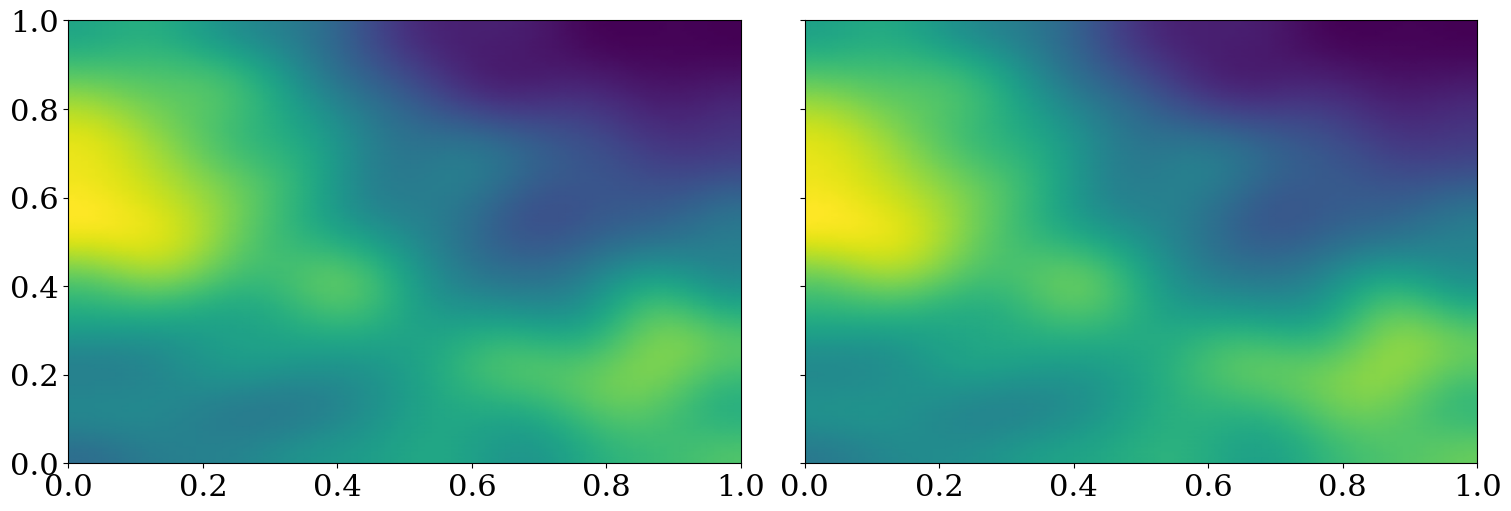

In [36]:
from scipy.interpolate import griddata

xgrid = np.linspace(0,1,100+1)
Y, X = np.meshgrid(xgrid, xgrid)
Y, X = torch.tensor(Y).reshape(-1,1).float().to(device),torch.tensor(X).reshape(-1,1).float().to(device)
C = torch.tensor(c).reshape(-1,1).float().to(device)

#X_star = torch.cat([X,Y,torch.ones_like(X)*20],axis = 1)
X_star = torch.cat([X,Y,C],axis = 1)
y_pred = model(X_star)

Y, X = np.meshgrid(xgrid, xgrid)
u = griddata(np.hstack([X.reshape(-1,1),Y.reshape(-1,1)]), y_pred.detach().numpy(), (X,Y), method='cubic')

print(u.shape,Y.shape,X.shape)
#inputs = np.load("../../../../data/Helmholtz_inputs.npy")   

_, axs = plt.subplots(1, 2,figsize = (15,5), layout='constrained', sharey=True)
axs[0].pcolormesh(X, Y, u[:,:,0], shading="gouraud")
#axs.set_xlabel("x"), axs[0].set_ylabel("y"), axs[0].set_title("c(x,y)")
axs[1].pcolormesh(X, Y, c, shading="gouraud")


# axs[2].pcolormesh(X, Y, y_test[0,:, :,0], shading="gouraud")
# axs[2].set_xlabel("x"), axs[2].set_title("u(x,y)_truth")

## DeepXDE attempt

In [3]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

#!export DGLBACKEND=tensorflow

# General parameters
nx_train = 500

iterations = 5000
learning_rate = 1e-3
num_dense_layers = 4
num_dense_nodes = 16
activation = "sin"

k0 = (1e3 / 20)**2

# Define sine function
if dde.backend.backend_name in ["tensorflow.compat.v1", "tensorflow"]:
    from deepxde.backend import tf

    sin = tf.sin
elif dde.backend.backend_name == "pytorch":
    import torch
    sin = torch.sin


geom = dde.geometry.Rectangle([0, 0], [1, 1])


def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    return -dy_xx - dy_yy - k0**2 * y 



def rbc(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

def lbc(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def dbc(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0)

def ubc(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1)



def neumann(x):
    grad = np.where((x[:,0:1] > 0.35) & (x[:,0:1] < 0.65), 1, 0)

    normal = -geom.boundary_normal(x)
    normal = np.array([normal]).T
    result = np.sum(grad * normal, axis=0)
    return result

def neumann_b(x):
    return 0

rc_inner = dde.icbc.NeumannBC(geom, neumann_b, rbc)
lc_inner = dde.icbc.NeumannBC(geom, neumann_b, lbc)
bc_inner = dde.icbc.NeumannBC(geom, neumann_b, dbc)
uc_inner = dde.icbc.NeumannBC(geom, neumann, ubc)




data = dde.data.PDE(
    geom,
    pde,
    [rc_inner, lc_inner,bc_inner,uc_inner],
    num_domain=nx_train**2,
    num_boundary=16 * nx_train,
    #num_test=nx_test**2,
)

net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], activation, "Glorot uniform"
)

model = dde.Model(data, net)

model.compile(
    "adam", lr=learning_rate, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=iterations)
#dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# # Plot the solution over a square grid with 100 points per wavelength in each direction
# Nx = int(np.ceil(wave_len * 100))
# Ny = Nx

# # Grid points
# xmin, xmax, ymin, ymax = [-length / 2, length / 2, -length / 2, length / 2]
# plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]
# points = np.vstack(
#     (plot_grid[0].ravel(), plot_grid[1].ravel(), np.zeros(plot_grid[0].size))
# )

# points_2d = points[:2, :]
# u = model.predict(points[:2, :].T)
# u = u.reshape((Nx, Ny))

# ide = np.sqrt(points_2d[0, :] ** 2 + points_2d[1, :] ** 2) < R
# ide = ide.reshape((Nx, Nx))

# u_exact = func(points.T)
# u_exact = u_exact.reshape((Nx, Ny))
# diff = u_exact - u
# error = np.linalg.norm(diff) / np.linalg.norm(u_exact)
# print("Relative error = ", error)

# plt.rc("font", family="serif", size=22)

# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(24, 12))

# matrix = np.fliplr(u).T
# matrix = np.ma.masked_where(ide, matrix)
# pcm = ax1.imshow(
#     matrix,
#     extent=[-length / 2, length / 2, -length / 2, length / 2],
#     cmap=plt.cm.get_cmap("seismic"),
#     interpolation="spline16",
#     label="PINN",
# )

# fig.colorbar(pcm, ax=ax1)

# matrix = np.fliplr(u_exact).T
# matrix = np.ma.masked_where(ide, matrix)
# pcm = ax2.imshow(
#     matrix,
#     extent=[-length / 2, length / 2, -length / 2, length / 2],
#     cmap=plt.cm.get_cmap("seismic"),
#     interpolation="spline16",
#     label="Exact",
# )

# ax1.set_title("PINNs")
# ax2.set_title("Exact")
# fig.colorbar(pcm, ax=ax2)

# # Add the boundary normal vectors
# p = inner.random_boundary_points(16 * nx_train)
# px, py = p.T
# nx, ny = inner.boundary_normal(p).T
# ax1.quiver(px, py, nx, ny)
# ax2.quiver(px, py, nx, ny)
# #plt.savefig("plot_manufactured.pdf")

Compiling model...
'compile' took 0.000120 s

Training model...



TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [33]:
dde.backend.backend_name

'tensorflow.compat.v1'

# Easier Helmholtz equation

In [2]:
def de(self,data_domain):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)

    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    ddu_y = torch.autograd.grad(
        du[:,1],data_domain, 
        grad_outputs=torch.ones_like(du[:,1]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    g = ((data_domain[:,2].reshape(-1,1))**2)*torch.sin(data_domain[:,0].reshape(-1,1)*data_domain[:,2].reshape(-1,1))*torch.sin(data_domain[:,1].reshape(-1,1)*data_domain[:,2].reshape(-1,1))
    f = ddu_x[:,0].reshape(-1,1) + ddu_y[:,1].reshape(-1,1) + (data_domain[:,2].reshape(-1,1)**2)*u.reshape(-1,1)
    return f + g


def bc(self,data_bc):
    #data_bc = torch.cat ([data_bc[:,0].reshape(-1,1),torch.zeros((data_bc.shape[0],1),requires_grad=True), data_bc[:,2].reshape(-1,1)],axis =1)
    u = self(data_bc)
    return u

FNN.de = de
FNN.bc = bc

In [3]:
from pyDOE import lhs

def samples_space(size,maxl=1):
    t_f_train = lhs(2, size)*maxl
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [4]:
def data_pde(size,minp,maxp):

    xy, param = samples_space(size),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    
    x,y, param  = torch.tensor(xy[:,0]).reshape(-1,1),torch.tensor(xy[:,1]).reshape(-1,1),torch.tensor(param).reshape(-1,1)

    #pde_domain = torch.tensor(np.hstack((xy,param.reshape(-1,1)))).float()
    pde_domain = torch.tensor(np.hstack((xy,torch.ones_like(x).float()*4*torch.pi))).float()

    bc_b = torch.cat([x,torch.zeros_like(x).float(),torch.ones_like(x).float()*4*torch.pi],axis = 1).float()

    bc_u = torch.cat([x,torch.ones_like(x).float(),torch.ones_like(x).float()*4*torch.pi],axis = 1).float()

    bc_l = torch.cat([torch.zeros_like(x).float(),y, torch.ones_like(x).float()*4*torch.pi],axis = 1).float()

    bc_r = torch.cat([torch.ones_like(x).float(),y, torch.ones_like(x).float()*4*torch.pi],axis = 1).float()

    return pde_domain,bc_b,bc_l,bc_u,bc_r

In [5]:
def train_adam(pinn,loss,optimizer,epochs,batch_size_,minval_param = 0.2,maxval_param = 2):
      print("Starting Adam Training")
      train_loss=[]
      
      for i in range(epochs):
        pde_domain,bc_b,bc_l,bc_u,bc_r = data_pde(batch_size_,minval_param,maxval_param)
        pde_domain,bc_b,bc_l,bc_u,bc_r = pde_domain.to(device),bc_b.to(device),bc_l.to(device),bc_u.to(device),bc_r.to(device)

        pde_domain = Variable(pde_domain,requires_grad=True)
        bc_b,bc_u = Variable(bc_b,requires_grad=True),Variable(bc_u,requires_grad=True)
        bc_l,bc_r = Variable(bc_l,requires_grad=True),Variable(bc_r,requires_grad=True)
        
        optimizer.zero_grad()

        pde_pred  = pinn.de(pde_domain)
        down_bc_pred,up_bc_pred = pinn.bc(bc_b),pinn.bc(bc_u)
        left_bc_pred,right_bc_pred = pinn.bc(bc_l),pinn.bc(bc_r)

        zeros = torch.zeros_like(pde_pred)

        loss_pde = loss(pde_pred,zeros)
        loss_dbc,loss_ubc = loss(down_bc_pred,zeros),loss(up_bc_pred,zeros)
        loss_lbc,loss_rbc = loss(left_bc_pred,zeros),loss(right_bc_pred,zeros)

        Loss =   loss_pde + loss_dbc + loss_ubc + loss_lbc + loss_rbc
        
        train_loss.append(Loss.item())

        if i % 100 == 0:
                print('Iter %d, Loss: %.5e, Loss_pde: %.5e,Loss_dbc: %.5e,Loss_ubc: %.5e,Loss_lbc: %.5e,Loss_rbc: %.5e' % (i, 
                                        Loss.item(),loss_pde.item(),loss_dbc.item(), loss_ubc.item(),loss_lbc.item(), loss_rbc.item()))      
                #print('Iter %d, Loss: %.5e, Loss_f: %.5e, Loss_pde: %.5e' % (i,Loss.item(),loss_f.item(),loss_pde.item()))      
        
        Loss.backward() 

        optimizer.step() 
                
      return train_loss

In [6]:
def train_LBFGS(pinn,loss,optimizer, sample_size = 100,minval_param = 0.2,maxval_param = 2):
    print("Starting Training: LBFGS optimizer")
    train_loss=[]

    pde_domain,bc_b,bc_l,bc_u,bc_r = data_pde(sample_size,minval_param,maxval_param)
    pde_domain,bc_b,bc_l,bc_u,bc_r = pde_domain.to(device),bc_b.to(device),bc_l.to(device),bc_u.to(device),bc_r.to(device)

    pde_domain = Variable(pde_domain,requires_grad=True)
    bc_b,bc_u = Variable(bc_b,requires_grad=True),Variable(bc_u,requires_grad=True)
    bc_l,bc_r = Variable(bc_l,requires_grad=True),Variable(bc_r,requires_grad=True)


    def loss_func_train():
        optimizer.zero_grad()
        
        pde_pred  = pinn.de(pde_domain)
        down_bc_pred,up_bc_pred = pinn.bc(bc_b),pinn.bc(bc_u)
        left_bc_pred,right_bc_pred = pinn.bc(bc_l),pinn.bc(bc_r)

        zeros = torch.zeros_like(pde_pred)

        loss_pde = loss(pde_pred,zeros)
        loss_dbc,loss_ubc = loss(down_bc_pred,zeros),loss(up_bc_pred,zeros)
        loss_lbc,loss_rbc = loss(left_bc_pred,zeros),loss(right_bc_pred,zeros)

        Loss =  (loss_pde + loss_dbc + loss_ubc + loss_lbc + loss_rbc)
        
        train_loss.append(Loss.item())

        print('Loss: %.5e, Loss_pde: %.5e,Loss_dbc: %.5e,Loss_ubc: %.5e,Loss_lbc: %.5e,Loss_rbc: %.5e' % ( 
                                        Loss.item(),loss_pde.item(),loss_dbc.item(), loss_ubc.item(),loss_lbc.item(), loss_rbc.item())) 
        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 
    return train_loss

In [22]:
epochs = 40000
nobs = 500
lr = 0.001

min_param , max_param = 3*np.pi, 5*np.pi

N_neurons = 60
layers = 4

model = FNN(3, 1, layers, N_neurons) 
model.to(device)

FNN(
  (modus): ModuleDict(
    (LinM1): Linear(in_features=3, out_features=60, bias=True)
    (NonM1): ReLU()
    (LinM2): Linear(in_features=60, out_features=60, bias=True)
    (NonM2): ReLU()
    (LinM3): Linear(in_features=60, out_features=60, bias=True)
    (NonM3): ReLU()
    (LinMout): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [23]:
loss = torch.nn.MSELoss(reduction ='mean')

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_history = train_adam(model,loss,optimizer,epochs,nobs,min_param,max_param)

optimizer = torch.optim.LBFGS(model.parameters(), 
    lr=lr, max_iter=50000, max_eval=None, 
    tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe" 
    )

loss_history_b = train_LBFGS(model,loss,optimizer, nobs*2,min_param,max_param)

Starting Adam Training
Iter 0, Loss: 7.82997e+03, Loss_pde: 7.82972e+03,Loss_dbc: 6.05785e-02,Loss_ubc: 6.19083e-02,Loss_lbc: 6.26616e-02,Loss_rbc: 5.93032e-02
Iter 100, Loss: 6.12100e+03, Loss_pde: 6.12100e+03,Loss_dbc: 1.05574e-04,Loss_ubc: 7.07341e-06,Loss_lbc: 4.99517e-05,Loss_rbc: 3.48502e-05
Iter 200, Loss: 6.27890e+03, Loss_pde: 6.27890e+03,Loss_dbc: 1.49028e-03,Loss_ubc: 8.97195e-04,Loss_lbc: 1.18527e-03,Loss_rbc: 9.04203e-04
Iter 300, Loss: 5.95390e+03, Loss_pde: 5.95390e+03,Loss_dbc: 6.40382e-04,Loss_ubc: 3.47892e-04,Loss_lbc: 4.78498e-04,Loss_rbc: 2.22982e-04
Iter 400, Loss: 6.06653e+03, Loss_pde: 6.06653e+03,Loss_dbc: 2.69657e-04,Loss_ubc: 1.37829e-05,Loss_lbc: 1.98804e-04,Loss_rbc: 2.09410e-04
Iter 500, Loss: 6.15738e+03, Loss_pde: 6.15737e+03,Loss_dbc: 3.93849e-03,Loss_ubc: 1.37782e-03,Loss_lbc: 1.90585e-03,Loss_rbc: 6.96076e-04
Iter 600, Loss: 6.27307e+03, Loss_pde: 6.27306e+03,Loss_dbc: 1.94739e-03,Loss_ubc: 1.34415e-04,Loss_lbc: 1.69284e-03,Loss_rbc: 1.15395e-03
Iter 7

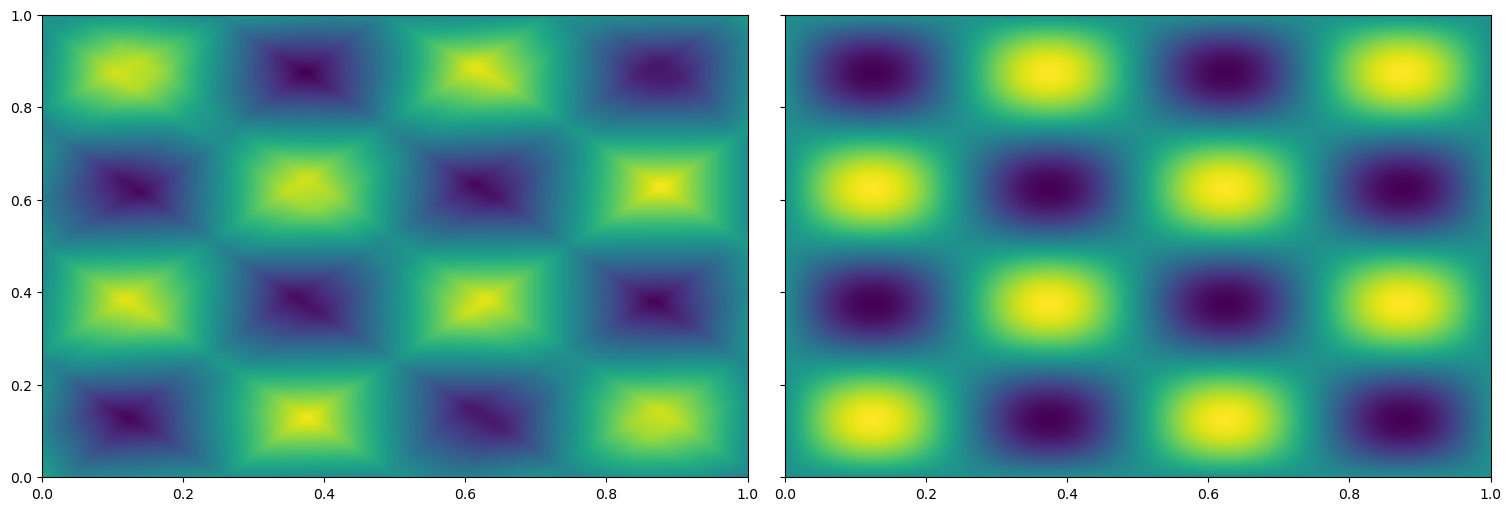

In [24]:
from scipy.interpolate import griddata

def exact_sol(x,y,k0 = 4*np.pi):
    return np.sin(k0*x)*np.sin(k0*y)

xgrid = np.linspace(0,1,100+1)
Y, X = np.meshgrid(xgrid, xgrid)

Y, X = torch.tensor(Y).reshape(-1,1).float().to(device),torch.tensor(X).reshape(-1,1).float().to(device)

X_star = torch.cat([X,Y,torch.ones_like(X)*4*np.pi],axis = 1)

#X_star = torch.cat([X,Y,C],axis = 1)
y_pred = model(X_star)

Y, X = np.meshgrid(xgrid, xgrid)
u = griddata(np.hstack([X.reshape(-1,1),Y.reshape(-1,1)]), y_pred.detach().numpy(), (X,Y), method='cubic')
exact = exact_sol(X,Y)


_, axs = plt.subplots(1, 2,figsize = (15,5), layout='constrained', sharey=True)
axs[0].pcolormesh(X, Y, u[:,:,0], shading="gouraud")
#axs.set_xlabel("x"), axs[0].set_ylabel("y"), axs[0].set_title("c(x,y)")
axs[1].pcolormesh(X, Y, exact, shading="gouraud")